# Mental Health in Tech Industry

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import pandas as pd
from helpers import *
from matplotlib.gridspec import GridSpec

pd.options.display.max_rows = None
pd.options.display.max_colwidth = None
sns.set_style("darkgrid")

### Connect DB

In [4]:
con = sqlite3.connect('./mental_health.sqlite')


def qry(query):
    """wrapper function for pd.read_sql_query with connector passed in

    Args:
        query (string): sql query string

    Returns:
        pd dataframe: query result convert into pd dataframe
    """
    return pd.read_sql_query(query, con)

In [5]:
all_tables = qry(
    "SELECT name FROM sqlite_master WHERE type='table';")
ans_df = qry("SELECT * FROM Answer")
q_df = qry("SELECT * FROM Question")
suv_df = qry("SELECT * FROM Survey")

ans_df.shape
bprint('All tables in the DB')
all_tables['shape'] = [suv_df.shape, ans_df.shape,  q_df.shape]
all_tables


All tables in the DB


,name,shape
0,Survey,"(5, 2)"
1,Answer,"(241116, 4)"
2,Question,"(106, 2)"


## EDA
To begin with, we want to know more about the participants of this survey.

From the survey, we can identiy subgroups like: age, gender, region, job related to IT, is remote work...

Looking into the data distribution of these groups give us more general information about the data.

In [6]:
def basic_info(q_id, col, is_country=False):
    res = qry(
        f"SELECT answer_text, question_text FROM Answer ans JOIN Question q ON ans.question_id = q.id WHERE q.id = {q_id};")
    res.rename(columns={'answer_text': col}, inplace=True)
    if is_country:
        return res[col]
    else:
        res = res[res[col] != '-1']
        return res[col]


age = basic_info(1, 'age')
gender = basic_info(2, 'gender')
country = basic_info(3, 'country', is_country=True)
self_employed = basic_info(5, 'self_employed')
company_size = basic_info(8, 'company_size')
is_tech = basic_info(9, 'is_tech')
is_remote = basic_info(118, 'is_remote')

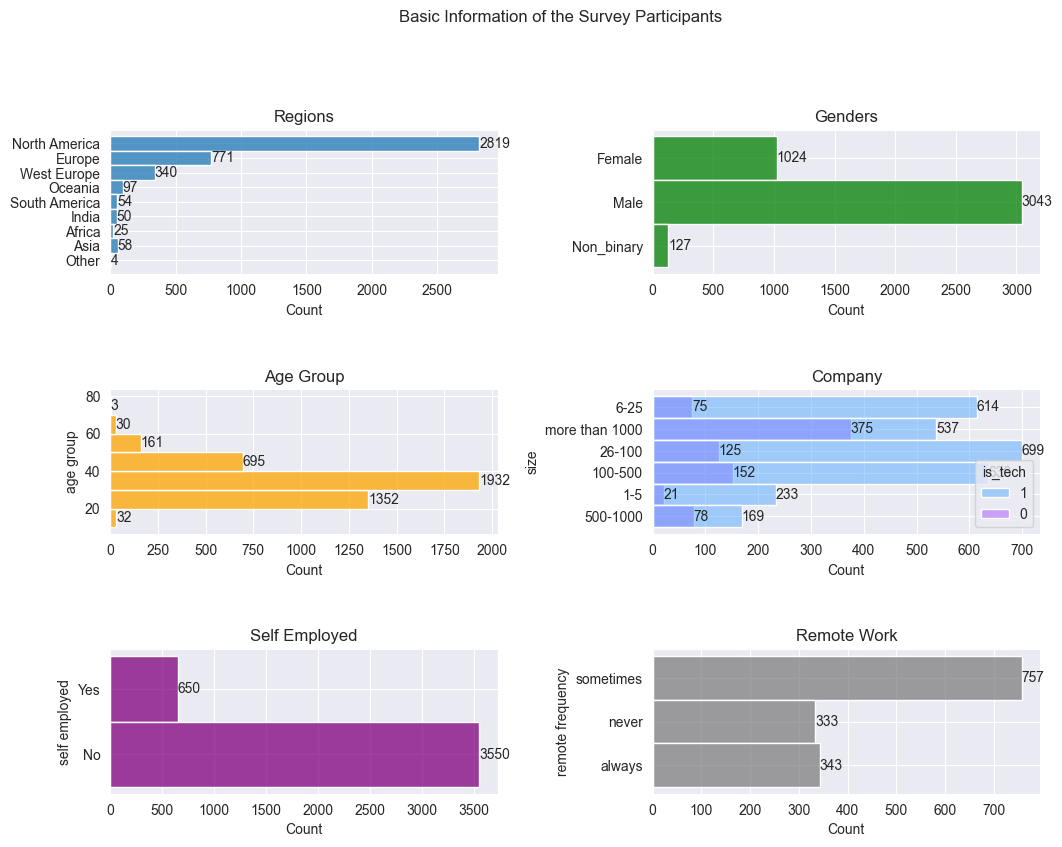

In [7]:
# regions
continent_ls = []
for c in country:
    c = ' '.join([el.capitalize() for el in c.split(' ')])
    c = c.split(',')[0]
    if c == 'Other' or c == '-1':
        continent_ls.append('Other')
    elif c == 'India':
        continent_ls.append('India')
    elif c in west_european_countries:
        continent_ls.append('West Europe')
    elif c == 'United States Of America':
        continent_ls.append('North America')
    elif c == 'Bosnia And Herzegovina':
        continent_ls.append('Europe')
    else:
        continent_ls.append(country_to_continent(c))
fs(12, 12)
gs = GridSpec(4, 2, wspace=0.4, hspace=0.8)
plt.suptitle('Basic Information of the Survey Participants')
plt.subplot(gs[0:1, 0:1])
ax = sns.histplot(y=continent_ls)
mark_bar(ax)
plt.title('Regions')


# gender (Using Non binary to include all the input other than Female and Male here)
capitalized_gender = [el.capitalize() for el in gender.to_list()]
parsed_gender = (['Non_binary' if (el != 'Female' and el !=
                 'Male') else el for el in capitalized_gender])
plt.subplot(gs[0:1, 1:2])

ax2 = sns.histplot(y=parsed_gender, color='g')
mark_bar(ax2)
plt.title('Genders')
plt.subplot(gs[1:2, 0:1])

parsed_age = [int(el) for el in age]
ax3 = sns.histplot(y=parsed_age, bins=[
                   10, 20, 30, 40, 50, 60, 70, 80], color='orange')
mark_bar(ax3)
plt.ylabel('age group')
plt.title('Age Group')

# company related: size, if is-tech
plt.subplot(gs[1:2, 1:2])

size_map = {'1-5': 1, '6-25': 2, '26-100': 3,
            '100-500': 4, '500-1000': 5, 'more than 1000': 6}
orderd_company_size = [size_map[el] for el in company_size.to_list()]

company_related = pd.DataFrame(
    {'size': company_size, 'is_tech': is_tech})

ax5 = sns.histplot(data=company_related, y='size',
                   hue='is_tech', palette='cool')
mark_bar(ax5)
plt.title('Company')
plt.ylabel('size')

# self-employed
plt.subplot(gs[2:3, 0:1])

parsed_age = [int(el) for el in age]
ax4 = sns.histplot(y=self_employed, color='purple')
mark_bar(ax4)
plt.yticks([0, 1], ['Yes', 'No'])
plt.ylabel('self employed')
plt.title('Self Employed')


# is remote
plt.subplot(gs[2:3, 1:2])
ax6 = sns.histplot(y=is_remote, color='grey')
mark_bar(ax6)
plt.title('Remote Work')
plt.ylabel('remote frequency')


plt.subplots_adjust(hspace=0.1, wspace=0.5)
s()

### 📝 Notes
`Locations`:
* Countries are grouped into regions for easier analysis.
* Around `67% of the participants are based in North America`, around \
  `26% in West Europe + Europe`. 
* West Europe is pulled out specifically, as this is the region that's known for \
* good citizen welfare, we'd like to know if this extends to the business world.

`Genders`:
* The number of male in this survey is three times more than female. We have a \
* small population of non-binary gender. 
* Are non-binary individuals more opened to discuss mental health ?

`Age Group`:
* The most common age group is 30~40 followed by 20~30, combined, they accounted \
* for more than 88% of the total age group.
* Are younger people more willing to talk about mental health in work place ?

`Company`:
* Most of the companies in this dataset are tech companies. 
* The big tech companies (>1000) might include the tech giants such as Google, \
  Apple, Netflix, ... How comfortable are the employees in these big tech companies \
  when it comes to discussion of mental health in work place ?

`Self Employed` and `Remote work`:
* More than 80% of the participants in this survey are not self-employed. 
* About 25% of the participants never have remote work experience.

## Answer predefined questions:

### 📊 Most common mental health illness
As we are looking into a mental health related survey, `what is the most common mental health illness people are suffering from in this survey` (based on the ones that shared) ?

Wordcloud is used to extract the most mentioned diagnosed or self-experienced illness:


Most mentioned mental illness in the survey: 


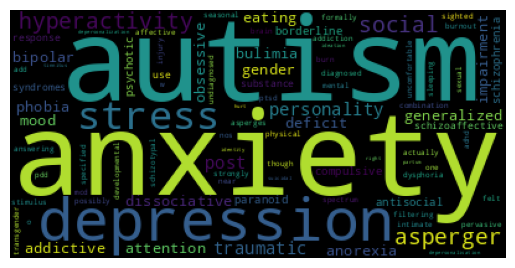

In [8]:
ans_condition = qry("""
SELECT
  DISTINCT id,
  question_text,
  ans.answer_text
FROM
  Question q JOIN Answer ans ON q.id = ans.question_id
WHERE
  (
    q.id IN (115, 116)
  )
""")

bprint('Most mentioned mental illness in the survey: ')
make_word_cloud(ans_condition.answer_text)

### 📝 Common Mental Illness

`Anxiety, Autism, Stress, Hyperactivity (ADHD), Depression`, etc... are some of \
the most common mental illness.

It is interesting that `autism is one of the most mentioned mental illness here`, \
as according to CDC (Centers for Disease Control and Prevention) only about 2.7% \
of the world's population has autism.In general male has 4 times the chance to \
be autistic than female. 

There are 3 times more male than female in this survey, so comparing to normal \
population, we should observe 1.3 times (30%) more autistic individual in this \
survery.

Does this mean that we have a higher proportion of autistic people in tech \
comparing to other divisions ? Or does autism bother people a lot in work-life \
that people stree more about it ?

### 📊 How people feel about the mental health related topics in the work place
After knowing what kind of mental health illness people have, we are curious about \
`how people feel about the mental health related topics in the work place`, and \
if there's difference between different subgroups such as gender, age, region, \
company size ?

Weighted mean is used here and further for positive sentiment analysis, taking \
value and frequency of survey answers into account.

* Are individuals aware of the mental health insurance coverage offered by their \
  workplace ?

* Are participants comfortable discussing mental health with colleagues ?

* Are participants comfortable discussing mental health with direct supervisors ?

* Do people think there'd be negative consequence if they discuss mental health \
  with their employers ?



In [9]:
def discuss_mental_health_at_work_qry(question_id, subgroup_cte_clause, subgroup_name):
    return qry(f"""
                WITH 
                q_cte AS 
                (
                    SELECT q.id, ans.user_id, ans.answer_text
                    FROM Question q JOIN Answer ans ON q.id = ans.question_id
                    WHERE q.id = {question_id}
                ),
                {subgroup_name}_cte AS 
                ({subgroup_cte_clause})
                SELECT 
                    q_cte.id AS question_id,
                    q_cte.answer_text AS answer, 
                    {subgroup_name}_cte.{subgroup_name},
                    COUNT(*) AS count_per_subgroup,
                    COUNT(*) * 1.0 / SUM(COUNT(*)) OVER (PARTITION BY {subgroup_name}_cte.{subgroup_name}) AS ratio
                FROM q_cte 
                JOIN {subgroup_name}_cte ON q_cte.user_id = {subgroup_name}_cte.user_id
                WHERE q_cte.answer_text <> '-1' AND {subgroup_name}_cte.{subgroup_name} <> '-1'
                GROUP BY q_cte.answer_text, {subgroup_name}_cte.{subgroup_name}
                """)


def score_map(ans, score):
    return {ans[i]: score[i] for i in range(len(ans))}


def df_score_ans(df, ans_score_map):
    df['ans_positive_score_encode'] = df.answer.apply(
        lambda i: ans_score_map[i])
    df['ans_score'] = df.ans_positive_score_encode * df.ratio
    df['id'] = np.arange(df.shape[0])
    return df


no_yes_dunno_map = score_map(['no', "i don't know", 'yes'], [-1, 0, 1])
no_yes_maybe_map = score_map(['no', "maybe", 'yes'], [-1, 0, 1])
no_yes_not_sure_map = score_map(['no', "i am not sure", 'yes'], [-1, 0, 1])

no_yes_some_of_them_map = score_map(['no', "some of them", 'yes'], [-1, 0, 1])


def positive_score_heatmap(subgroup_name, scored_df_ls):
    scored_q15, scored_q18, scored_q19, scored_q98 = scored_df_ls

    score_15 = scored_q15.groupby(subgroup_name).ans_score.sum()
    score_18 = scored_q18.groupby(subgroup_name).ans_score.sum()
    score_19 = scored_q19.groupby(subgroup_name).ans_score.sum()
    score_98 = scored_q98.groupby(subgroup_name).ans_score.sum()
    total = pd.DataFrame(
        {'I know my employer-covered \n MH options': score_15, 'I feel comfortable discussing\n MH  with colleagues': score_18,
         'I feel comfortable discussing\n MH  with direct supervisor': score_19, 'I think discussing MH with employer\n as no negative career impact': score_98*(-1)})
    plt.title(subgroup_name.capitalize(), y=1.01)
    sns.heatmap(total.T, cmap='vlag', annot=True)
    plt.xlabel('')
    if subgroup_name == 'company_size':
        plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['1-5', '6-25', '26-100',
                   '100-500', '500-1000', 'more than \n 1000'])

In [10]:
# subgroup cte clauses

# unify gender names
gender_cte_clause = """
SELECT q.id, ans.user_id, 
CASE 
    WHEN ans.answer_text IN ('female', 'femmina') THEN 'female'
    WHEN ans.answer_text IN ('male', 'masculine', 'masculino') THEN 'male'
    WHEN ans.answer_text = '-1' THEN '-1'
    WHEN ans.answer_text <> 'female' AND ans.answer_text <> 'male' THEN 'non-binary'
END AS gender
FROM Question q JOIN Answer ans ON q.id = ans.question_id
WHERE q.id = 2
"""

# bin age
age_cte_clause = """
SELECT q.id, ans.user_id, 
CASE 
    WHEN ans.answer_text BETWEEN 10 AND 20 THEN '10-20'
    WHEN ans.answer_text BETWEEN 21 AND 30 THEN '21-30'
    WHEN ans.answer_text BETWEEN 31 AND 40 THEN '31-40'
    WHEN ans.answer_text BETWEEN 41 AND 50 THEN '41-50'
    WHEN ans.answer_text BETWEEN 51 AND 60 THEN '51-60'
    WHEN ans.answer_text BETWEEN 61 AND 99 THEN 'Over 60'
END AS age
FROM Question q JOIN Answer ans ON q.id = ans.question_id
WHERE q.id = 1
"""
# identify region which are not other
region_cte_clause = """
SELECT q.id, ans.user_id, ans.answer_text region
FROM Question q JOIN Answer ans ON q.id = ans.question_id
WHERE q.id = 1000 AND ans.answer_text <> 'Other'
"""
# bin company size
company_size_cte_clause = """
SELECT q.id, ans.user_id, ans.answer_text, 
CASE 
    WHEN ans.answer_text = '1-5' THEN 1
    WHEN ans.answer_text = '6-25' THEN 2
    WHEN ans.answer_text = '26-100' THEN 3
    WHEN ans.answer_text = '100-500' THEN 4
    WHEN ans.answer_text = '500-1000' THEN 5
    WHEN ans.answer_text = 'more than 1000' THEN 6
END AS company_size
FROM Question q JOIN Answer ans ON q.id = ans.question_id
WHERE q.id = 8
"""

In [11]:
# run query for subgroups

# gender
q14_res_gender = discuss_mental_health_at_work_qry(
    14, gender_cte_clause, 'gender')
q18_res_gender = discuss_mental_health_at_work_qry(
    18, gender_cte_clause, 'gender')
q19_res_gender = discuss_mental_health_at_work_qry(
    19, gender_cte_clause, 'gender')
q98_res_gender = discuss_mental_health_at_work_qry(
    98, gender_cte_clause, 'gender')


# age
q14_res_age = discuss_mental_health_at_work_qry(14, age_cte_clause, 'age')
q18_res_age = discuss_mental_health_at_work_qry(18, age_cte_clause, 'age')
q19_res_age = discuss_mental_health_at_work_qry(19, age_cte_clause, 'age')
q98_res_age = discuss_mental_health_at_work_qry(98, age_cte_clause, 'age')

# region
q14_res_region = discuss_mental_health_at_work_qry(
    14, region_cte_clause, 'region')
q18_res_region = discuss_mental_health_at_work_qry(
    18, region_cte_clause, 'region')
q19_res_region = discuss_mental_health_at_work_qry(
    19, region_cte_clause, 'region')
q98_res_region = discuss_mental_health_at_work_qry(
    98, region_cte_clause, 'region')


# company size
q14_res_company_size = discuss_mental_health_at_work_qry(
    14, company_size_cte_clause, 'company_size')
q18_res_company_size = discuss_mental_health_at_work_qry(
    18, company_size_cte_clause, 'company_size')
q19_res_company_size = discuss_mental_health_at_work_qry(
    19, company_size_cte_clause, 'company_size')
q98_res_company_size = discuss_mental_health_at_work_qry(
    98, company_size_cte_clause, 'company_size')


# score the answers

# gender
scored_q14_gender = df_score_ans(q14_res_gender, no_yes_not_sure_map)
scored_q18_gender = df_score_ans(q18_res_gender, no_yes_maybe_map)
scored_q19_gender = df_score_ans(q19_res_gender, no_yes_maybe_map)
scored_q98_gender = df_score_ans(q98_res_gender, no_yes_maybe_map)

# age
scored_q14_age = df_score_ans(q14_res_age, no_yes_not_sure_map)
scored_q18_age = df_score_ans(q18_res_age, no_yes_maybe_map)
scored_q19_age = df_score_ans(q19_res_age, no_yes_maybe_map)
scored_q98_age = df_score_ans(q98_res_age, no_yes_maybe_map)


# region
scored_q14_region = df_score_ans(q14_res_region, no_yes_not_sure_map)
scored_q18_region = df_score_ans(q18_res_region, no_yes_maybe_map)
scored_q19_region = df_score_ans(q19_res_region, no_yes_maybe_map)
scored_q98_region = df_score_ans(q98_res_region, no_yes_maybe_map)


# company size
scored_q14_company_size = df_score_ans(
    q14_res_company_size, no_yes_not_sure_map)
scored_q18_company_size = df_score_ans(q18_res_company_size, no_yes_maybe_map)
scored_q19_company_size = df_score_ans(q19_res_company_size, no_yes_maybe_map)
scored_q98_company_size = df_score_ans(q98_res_company_size, no_yes_maybe_map)

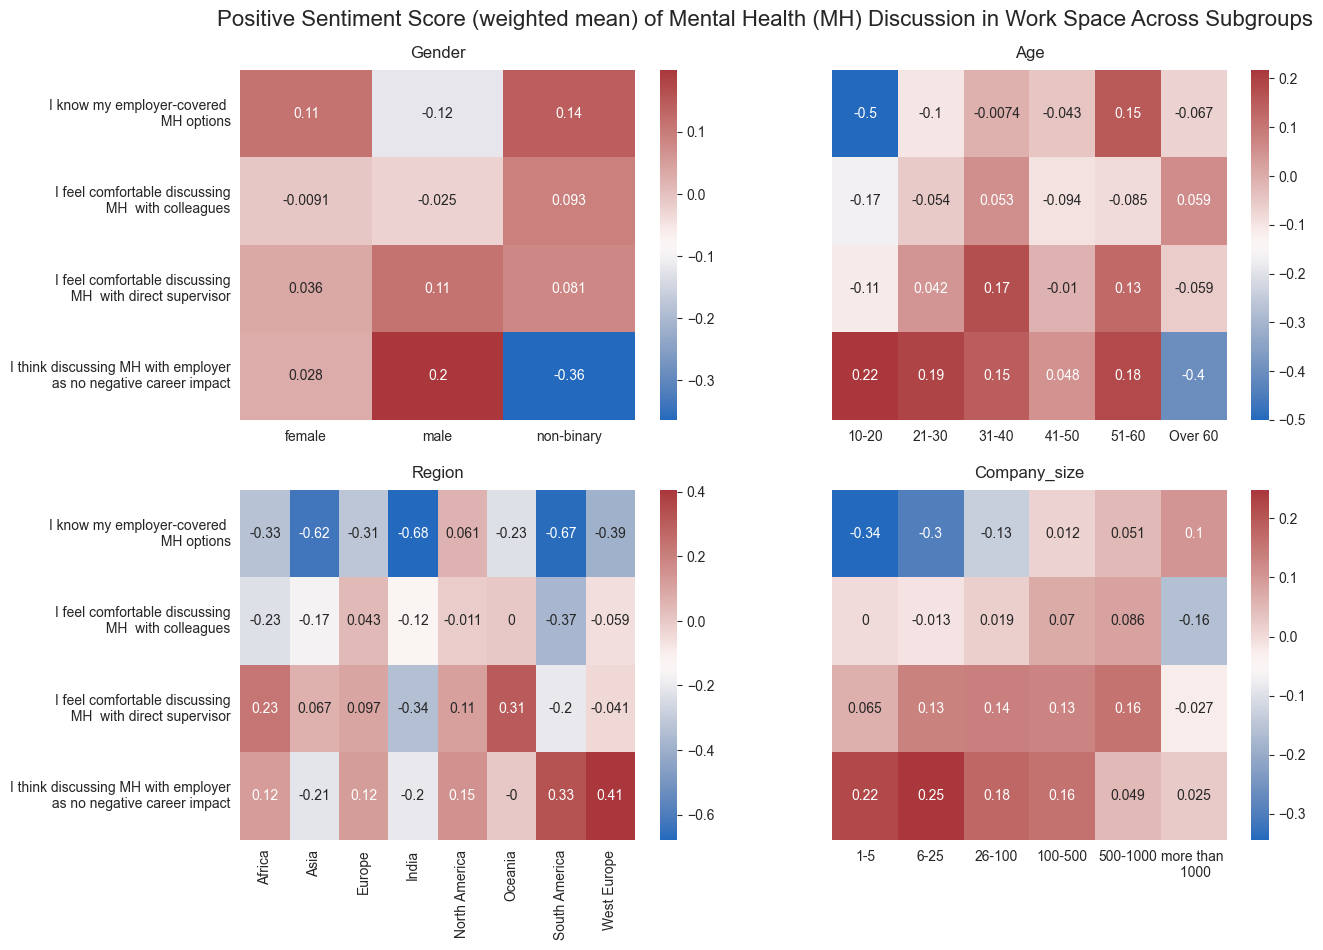

In [12]:
fs(14, 10)
plt.suptitle(
    'Positive Sentiment Score (weighted mean) of Mental Health (MH) Discussion in Work Space Across Subgroups', y=0.94, fontsize=16)

plt.subplot(2, 2, 1)
gender_map = positive_score_heatmap('gender', [
                                    scored_q14_gender, scored_q18_gender, scored_q19_gender, scored_q98_gender])
plt.subplot(2, 2, 2)
age_map = positive_score_heatmap(
    'age', [scored_q14_age, scored_q18_age, scored_q19_age, scored_q98_age])
plt.yticks([])

plt.subplot(2, 2, 3)
region_map = positive_score_heatmap('region', [
                                    scored_q14_region, scored_q18_region, scored_q19_region, scored_q98_region])
plt.subplot(2, 2, 4)
company_size_map = positive_score_heatmap('company_size', [
                                          scored_q14_company_size, scored_q18_company_size, scored_q19_company_size, scored_q98_company_size])
plt.yticks([])
s()

📝 Mental Health(MH) in work place across different subgroups
- gender:

`Male` has the `least awareness` about their company-provided mental health benefits, \
but they are `the most optimistic` about have no adverse consequence when discussing \
MH with employers. 

`Non-binary` gender individuals are more willing to `discuss mental health` \
`with colleagues but not with supervisors`, and they are also the only gender \
group that is `pessimistic` about the negative impact of discussing MH with employers.


- age:

People in 51-60 age group is the only group that has positive score on MH medical \
coverage. 10-20 individual knows the least about it.

All groups except over 60 age group feel more comfortable discussing MH with \
supervisor than colleagues.

All groups have positive sentiment about career not impacted discussing MH with \
employers.

- region:

`West european` individuals are the `most optimistic` in believing MH discussion \
won't hinder career. 

`North american` people `know their MH coverage the most`. However, as there is \
not public health insurance, it make sense that people would pay more attention \
to these health care related benefits.

South american people have very negative sentiment about discussing MH with \
colleagues.

Indians on the other hand have very negative sentiment about discussing MH with \
direct supervisors.

- company_size

Interestingly `the size of the company` has `positive correlation with the` \
`awareness of MH coverage` by company, and has `negative correlation with` \
`the optimisticness` about discussing MH with employers.
  
Also worth notice is that, the company size has almost positive correlation with \
the comfortable level of discussing MH with colleagues and supervisors EXCEPT \
for the companies with > 1000 ppl. \
In fact, `ppl working in these very big companies (>1000)` \
seems to be more `closed and pessimistic` about MH discussion in the work place.


### 📊 How are people with mental health doing in business across time
Various demographic groups hold diverse attitudes toward addressing mental health \
concerns in the workplace, and they also have varying perceptions regarding the \
potential outcomes of disclosing their mental health conditions.

As mental health gain more and more attention in the social media these years, \
people are more open to talk about it, but does this ACTUALLY apply in the business world ?


Here we are looking at `how people with mental health are doing in business` \
`across time` with these questions:

- Are people with MH issue feeling more secure in the work place with the advance \
  of time (2017 ~ 2019) ?

- What's the proportion of people suffering from MH issue ? 

- How many of them have disclosed this at work and are known as person with MH issue ?

- Are there any negative impact for them ?

In [20]:
# mental health disclosure through out years
open_mental_health = qry("""
WITH has_mh AS (
SELECT
CASE
WHEN answer_text = 'yes' THEN 1
WHEN answer_text = 'possibly' THEN 0.2
WHEN answer_text = 'maybe' THEN 0.1
WHEN answer_text = 'don''t know' THEN 0
WHEN answer_text = 'no' THEN 0
END AS answer_numeric,
user_id,
survey_id,
question_id
FROM Answer ans
WHERE question_id = 33 AND survey_id <> 2016
),
has_identified AS (
SELECT
user_id,
survey_id,
question_id,
answer_text
FROM Answer ans
WHERE question_id = 78
),
has_impacted AS (
SELECT
user_id,
survey_id,
question_id,
CASE
WHEN answer_text = 1 THEN 1
WHEN answer_text = -1 THEN 0 
WHEN answer_text = 0 THEN 0
END AS answer_numeric
FROM Answer ans
WHERE question_id = 79
)
SELECT 
has_mh.survey_id year,
COUNT(has_mh.user_id) total,
SUM(has_mh.answer_numeric) AS has_mental_health,
SUM(has_identified.answer_text) AS has_openly_identified, 
SUM(has_impacted.answer_numeric) AS has_negatively_impacted
FROM
has_mh
JOIN has_identified ON has_mh.user_id = has_identified.user_id
JOIN has_impacted ON has_impacted.user_id = has_identified.user_id
GROUP BY has_mh.survey_id
""")

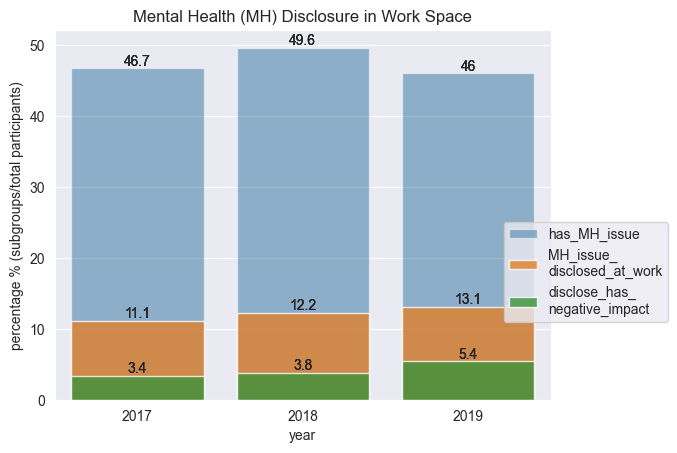

In [21]:
open_mental_health.has_mental_health = (
    open_mental_health.has_mental_health.apply(lambda i: round(i)))

ax1 = sns.barplot(x=open_mental_health.year,
                  y=round(open_mental_health.has_mental_health*100/open_mental_health.total, 1), label='has_MH_issue', alpha=0.5)

ax2 = sns.barplot(x=open_mental_health.year,
                  y=round(open_mental_health.has_openly_identified*100/open_mental_health.total, 1), label='MH_issue_\ndisclosed_at_work', alpha=0.8)

ax3 = sns.barplot(x=open_mental_health.year,
                  y=round(open_mental_health.has_negatively_impacted*100/open_mental_health.total, 1), label='disclose_has_\nnegative_impact', alpha=0.8)
plt.title('Mental Health (MH) Disclosure in Work Space')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 0.5))
plt.ylabel('percentage % (subgroups/total participants)')

mark_bar(ax1)
mark_bar(ax2)
mark_bar(ax3)

### 📝 Findings:
Around `46~50 %` of the survey participants `suffer from MH` across the years (2017~2019).

It is unfortunate that despite of the higher awareness in social media, \
`higher percentage` of people who `disclosed their mental health situation` at \
work were `negatively impacted` through time (3.4 -> 3.8 -> 5.4). 

However, it is good that there are `higher percentage of people willing to disclose` \
their condition (11.1 -> 12.2 -> 13.1). This can help raise the awareness in the \
work environment in general !

I guess the data for corona time would be highly interesting, if companies can \
take good care of their employees in difficult times, it provides more secure to \
the society.

### 📊 Do people in tech value companies that provide better mental health benefits ?  

- Is the mental health satisfaction of the current company better than the previous one ?
  
- Are people more satisfied with the physical or mental health perks provided by the company ?
  
- Is there a difference with the evolve of time ?


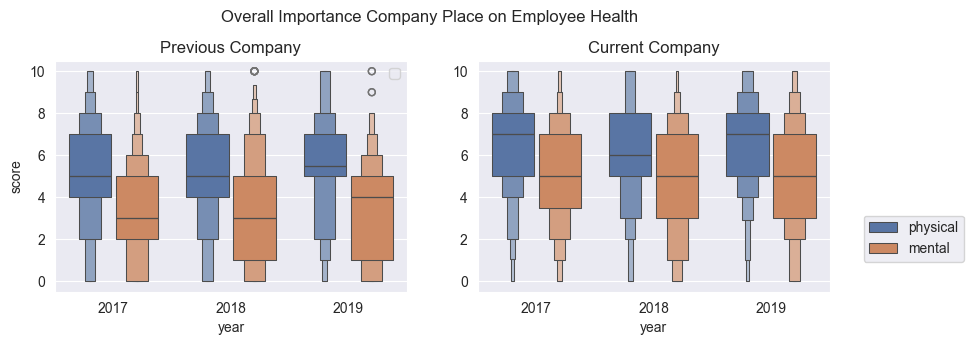

In [15]:
current_company = qry("""
 SELECT 
 ans.survey_id year, ans.question_id q_id, ans.answer_text*1.0 answer
 FROM 
 Answer ans
 WHERE
 ans.question_id IN (64, 65) 
 AND
 ans.answer_text <> -1
""")

previous_company = qry("""
 SELECT 
 ans.survey_id year, ans.question_id q_id, ans.answer_text answer
 FROM 
 Answer ans
 WHERE
 ans.question_id IN (76, 77) 
 AND
 ans.answer_text <> -1
""")


def curr_prev_comapre(df):
    df.year = df.year.apply(lambda i: str(i))
    df.answer = df.answer.apply(lambda i: int(i))
    df['question'] = df.q_id.apply(
        lambda i: 'physical' if i % 2 == 0 else 'mental')
    return df


prev_company = curr_prev_comapre(previous_company)
curr_company = curr_prev_comapre(current_company)

fs(10, 3)
plt.suptitle('Overall Importance Company Place on Employee Health', y=1.05)
plt.subplot(1, 2, 1)
sns.boxenplot(data=prev_company, x='year',
              y='answer', hue='question', palette='deep', gap=.1)
plt.legend('')
plt.ylabel('score')
plt.title('Previous Company')
plt.subplot(1, 2, 2)
sns.boxenplot(data=curr_company, x='year',
              y='answer', hue='question', palette='deep', gap=.1)
plt.ylabel('')
plt.title('Current Company')
plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0.1))
s()

### 📝 Findings
In all three years, `people give higher mental and physical health score` \
`for their current company`.

The score of all physical health is higher than its mental health counter part. 

We can imagine that companies are providing more physical perks like gym or bikes, \
but investing less in employee physiotherapy or other MH related benefits. \
The highest MH score median is around 5, companies should really do more research \
and know the need to their employee better.

There's `not so much change` between the mental and physical score `through out the years`.

### 📊 What can companies do to improve general mental health in work place ?

During the corona time, many companies have switched to `remote working mode`, \
and some never go back !

Nowadays, being able to work remotely has been advertised as a perk by many tech \
companies.

Many employees that have tried remote working also have very high intent to stay \
in this mode, or at least in
hybrid work mode.

The time span of this survey is not covering the corona time (2020~2022), we can \
look into the remote_work subgroup to see if remote work has positive influence on MH.

In this survey, there's no question directly about participant's mental health \
situation.

So questions that indicate the relax-level,  openess, optimisticness are used \
as metrics for MH evaluation here.

- Is it easy to take sick leaves on mental illness ?
  
- Would you be willing to mention your mental illness in job interviews ?
  
- Do you think talking to employers about your mental illness would not affect \
  your career ?

In [16]:
take_leave = """
CASE
    WHEN answer_text = 'very difficult' THEN -1
    WHEN answer_text = 'difficult' THEN -0.7
    WHEN answer_text = 'somewhat difficult' THEN -0.5
    WHEN answer_text = 'neither easy nor difficult' THEN 0.2
    WHEN answer_text = "i don't know" THEN 0
    WHEN answer_text = 'somewhat easy' THEN 0.5
    WHEN answer_text = 'very easy' THEN 1
    END AS txt
"""

job_interview = """
CASE
    WHEN answer_text = 'maybe' THEN 0
    WHEN answer_text = 'yes' THEN 1
    WHEN answer_text = 'no' THEN -1
    END AS txt

"""

talk_employer = """
CASE
    WHEN answer_text = 'maybe' THEN 0
    WHEN answer_text = 'yes' THEN -1
    WHEN answer_text = 'no' THEN 1
    END AS txt

"""


def remote_query(query, q_id):
    return qry(f"""
            WITH 
            is_remote AS (
                SELECT user_id, question_id,
                CASE
                WHEN answer_text = 'always' THEN 1
                WHEN answer_text = 'sometimes' THEN 0.5
                WHEN answer_text = 'never' THEN 0
                END AS txt
                FROM Answer ans
                WHERE answer_text <> '-1' AND question_id = 118
            ),
            has_disorder AS (
                SELECT user_id, question_id,
                {query}
                FROM Answer ans
                WHERE answer_text <> '-1' AND question_id = {q_id}
            )
            
            SELECT rm.txt remote_frequency, AVG(dis.txt) weighted_positive_sentiment_score
            FROM is_remote rm JOIN has_disorder dis ON rm.user_id = dis.user_id
            
            GROUP BY rm.txt
            """)

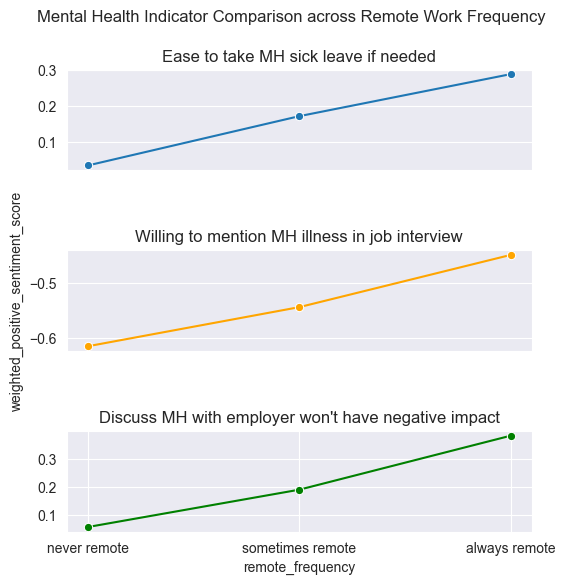

In [17]:
take_leave_df = remote_query(take_leave, 17)

job_interview_df = remote_query(job_interview, 12)

talk_employer_df = remote_query(talk_employer, 104)
fs(6, 6)
plt.subplot(3, 1, 1)
plt.suptitle("Mental Health Indicator Comparison across Remote Work Frequency")
sns.lineplot(take_leave_df, x='remote_frequency',
             y='weighted_positive_sentiment_score', marker='o')
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('Ease to take MH sick leave if needed')

plt.subplot(3, 1, 2)

sns.lineplot(job_interview_df, x='remote_frequency',
             y='weighted_positive_sentiment_score', color='orange', marker='o')
plt.xticks([])
plt.xlabel('')
plt.title('Willing to mention MH illness in job interview')

plt.subplot(3, 1, 3)

sns.lineplot(talk_employer_df, x='remote_frequency',
             y='weighted_positive_sentiment_score', color='green', marker='o')
plt.title("Discuss MH with employer won't have negative impact")

plt.ylabel('')
plt.xticks([0, 0.5, 1], ['never remote', 'sometimes remote', 'always remote'])
plt.subplots_adjust(hspace=0.8)
s()

### 📝 Findings:

`All three metrics have positive correlation with the increase of remote work frequency`.

Seems like remote work is a great approach to improve mental health in the work space !

Employees are more comfortable taking sick leaves for mental health issues when they need one.

Though in all three frequency groups, people have negative sentiment about mentioning \
it in job interviews, people who work remote more are more open about it.

And when it comes to comparing the always remote group with the other two groups \
regarding negative impact on discussing mental health with employers, the score \
is more than 7x the score of never remote, and around 2x than the sometimes remote group.

Working remotely enables people to have more control over their time, and also \
means less interaction with colleagues, since there's higher number of autistic \
people in the tech industry, they would feel more relaxed in remote working environment. 


### 💡 Further Suggestions for the Analysis:
1. Assign sentiment score for more questions/ answers and run cross queries to \
   define the subgroup of participants that have the most positive sentiment for \
   the mental health in the workplace.
   
2. Perform testing for the hypothesis to make the results more robust.
3. Identify and cluster users with similar answers using ML algorithms.

### 🦄 Concluding Remarks:
1. Most people are more comfortable discussing mental health issue with their \
   direct supervisors than with colleagues, irrespective of their demographic \
   characteristics. And they believe that the discussion of MH with employers \
   won't have negative impact on their career.
   
2. Male are the most optimistic gender group about mental health discussion in \
   work place despite of their little knowledge of mental health related benefits.
   
3. Binary people are open to discuss mental health with peers (colleagues) but \
   not so much with supervisors and employers. They are the rare group that feel \
   very pessimistic about the consequence of the disussion. 
   
4. People working in companies with more than 1000 people are the least comfortable \
   discussing mental health with either colleagues or supervisors, and higher \
   proportion of them also feel the discussion would impact their career.
   
5. Through the progression of the year higher percentage of people are openly \
   identified with mental health issues in the work place, but also more of them \
   feel the disclosure has impact on their career.
   
6. Comparing current and previous jobs, people are more satisfied with the effort \
   the current company placed on mental and physical health for all three years. \
   However, companies always place much more emphasis on physical health.
   
7. Remote work subgroup in this survey have shown the highest level of open, \
   relaxed and optimistic sentiment when it comes to MH issue with coworkers, \
   supervisor, and taking of sick leaves.